In [1]:
import os
#import nibabel as nib
import numpy as np
import cv2
# import math
import torch
import scipy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import sys
sys.path.append('../')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps
print(f"[Using {device} device]")

[Using cpu device]


### Utility functions

In [3]:
def get_glioma_indices(mask: torch.Tensor) -> tuple[int, int]:
    glioma_indices = torch.nonzero((mask > 0))[:, 1]
    if len(glioma_indices) == 0:
        return 0, 0

    first = glioma_indices[0].item()
    last = glioma_indices[-1].item()

    return first, last

def plot_tumour(mask: torch.Tensor):
    """Plot individual slices of the tumour in one figure."""
    
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(mask)
    print("Tumour indices: ", first, last)

    length = last - first + 1
    n_graphs = (length) // 4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0
    for i in range(first, last):
        if j >= len(axs):
            break
        axs[j].imshow(mask[0, i, :, :], cmap="magma")
        axs[j].axis("off")
        axs[j].set_title(f"mask slice {i}", fontsize=9)
        j += 1

    plt.show()

def plot_cuts(cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
        tmp_cut = torch.clone(cut)
        if plot_click:
            tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        axs[j].imshow(tmp_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

def plot_cut(cut, cmap='magma'):
    tmp_cut = torch.clone(cut)
    tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
    plt.imshow(tmp_cut, cmap=cmap)

def plot_cuts_with_seq(cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = 4
    cols = 3
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0
    
    for i, cut in enumerate(cuts):
        if j >= len(axs): 
            break
        
        # if len(cut.shape) == 3:
        #     cut = cut.squeeze(0)
        
        tmp_cut = torch.clone(cut[0])
        if plot_click:
            tmp_cut[cut[0].shape[0]//2, cut[0].shape[0]//2] = 2
        axs[j].imshow(cut[1], cmap='gray')
        axs[j].axis('off')
        axs[j].set_title(f't1 cut {i}', fontsize=9)
        axs[j+1].imshow(cut[2], cmap='gray')
        axs[j+1].axis('off')
        axs[j+1].set_title(f't2 cut {i}', fontsize=9)
        axs[j+2].imshow(tmp_cut, cmap=cmap)
        axs[j+2].axis('off')
        axs[j+2].set_title(f'seg cut {i}', fontsize=9)
        j += 3

    plt.show()   

def plot_tumour_with_true(y_true: torch.Tensor, y_pred: torch.Tensor):
    # Compute number of slices with the tumour
    first, last = get_glioma_indices(y_pred)
    print("Tumour indices: ", first, last)

    length = last - first + 1
    n_graphs = (length) // 4
    rows = n_graphs
    cols = 4
    res = cols if cols > rows else rows

    colormap = {
        'bg': 'black',
        'pred': 'purple',
        'true': 'red',
        'overlap': 'orange',
        'click': 'yellow'
    }
    cmap = ListedColormap([colormap['bg'], colormap['pred'], colormap['true'], colormap['overlap']])

    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res * 2, res * 2))
    axs = axs.flatten()
    j = 0

    for i in range(first, last):
        if j >= len(axs):
            break
        axs[j].imshow(y_true[0, i, :, :] + y_pred[0, i, :, :], cmap=cmap)
        axs[j].axis("off")
        axs[j].set_title(f"mask slice {i}", fontsize=9)
        j += 1

    plt.show()

def plot_cuts_with_true(cuts: list[torch.Tensor], true_cuts: list[torch.Tensor], plot_click=True, cmap='magma'):
    rows = len(cuts)//4
    cols = 4
    res = cols if cols > rows else rows
    # print(rows)
    
    # Plot them
    fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
    axs = axs.flatten()
    j = 0

    colormap = {
        'bg': 'black',
        'pred': 'purple',
        'true': 'red',
        'overlap': 'orange',
        'click': 'yellow'
    }
    cmap = ListedColormap([colormap['bg'], colormap['pred'], colormap['true'], colormap['overlap'], colormap['click']])
    
    for i, (cut, true_cut) in enumerate(zip(cuts, true_cuts)):
        if j >= len(axs): 
            break
        
        if len(cut.shape) == 3:
            cut = cut.squeeze(0)
            true_cut = true_cut.squeeze(0)
        
        tmp_cut = torch.clone(cut)
        tmp_true_cut = torch.clone(true_cut)
        tmp_true_cut[tmp_true_cut == 1] = 2
        
        if plot_click:
            tmp_cut[cut.shape[0]//2, cut.shape[0]//2] = 2
        
        axs[j].imshow(tmp_cut + tmp_true_cut, cmap=cmap)
        axs[j].axis('off')
        axs[j].set_title(f'cut {i}', fontsize=9)
        j += 1

    plt.show()   

### Pipeline

In [4]:
cutsize = 48

#### Segmentation

In [6]:
from src.model.segmentation import Unet
from src.data.data_generator import MRIDataset
from src.losses.dice import dice_coefficient

loading the segmentation model

In [7]:
model = Unet(in_channels=2, out_channels=1, blocks=3).to(device)

checkpoint = torch.load(os.path.join("./models", "segmentation_model.pt"), map_location=device)
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

**Loading the data**

In [9]:
new_data = MRIDataset(
    ["./data/vs_gk_30/vs_gk_t1_refT2.nii.gz"],
    ["./data/vs_gk_30/vs_gk_t2_refT2.nii.gz"],
    ["./data/vs_gk_30/vs_gk_seg_refT2.nii.gz"],
    (48, 256, 256),
    clicks=None,
)

**Generating initial segmentation**

In [10]:
x, y = new_data[0]
with torch.no_grad():
    y_pred = model(x.unsqueeze(0).to(device))

In [11]:
y_threshed = (y_pred > 0.6).type(torch.float32).cpu()
print('Initial segmentation DSC: ', dice_coefficient(y_threshed, y).item())

Initial segmentation DSC:  0.9035974740982056


Tumour indices:  25 41


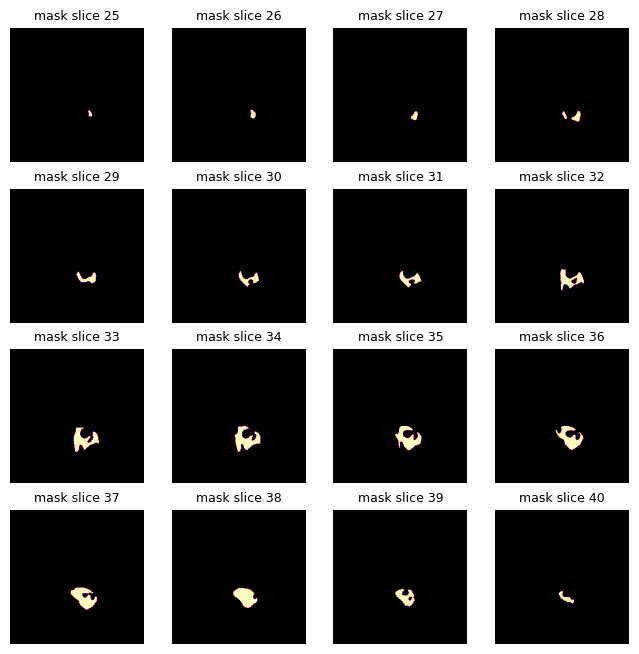

In [13]:
plot_tumour(y_threshed[0])

Tumour indices:  24 42


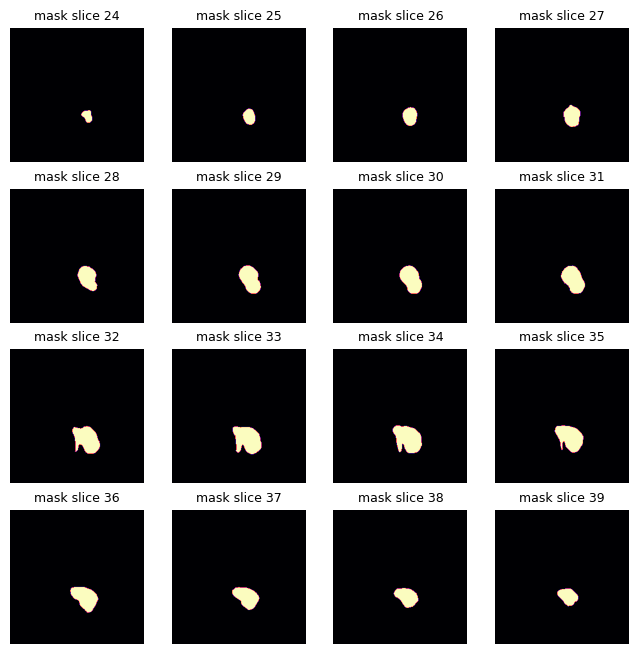

In [14]:
plot_tumour(y)

#### Generating clicks

In [15]:
from src.data.utils import _select_points

def get_border(mask: torch.Tensor):
    mask = mask.numpy()
    erosion_kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(3, 3))
    eroded_seg = cv2.erode(mask, kernel=erosion_kernel)
    border = mask - eroded_seg
    
    return border

def get_potential_coords(y_coords: list, diff_coords: list):
    # get coords (potential clicks), 
    # that are also in the original seg
    potential_clicks = []
    for coord in y_coords:
        if coord in diff_coords:
            potential_clicks.append(coord)
    
    return potential_clicks

def get_clicks(mask: torch.Tensor, pred: torch.Tensor, clicks_num=2, clicks_dst=4, seed=None) -> torch.Tensor:
    border = get_border(mask)
    
    if len(mask[mask == 1]) > len(pred[pred == 1]):
        dst = scipy.ndimage.distance_transform_edt(1 - pred)
    else:
        dst = scipy.ndimage.distance_transform_edt(pred)
        # dst = 1 - dst
        # dst[dst == 1] = 0
        # dst[dst != 0] -= np.min(dst)
    weighted_border = dst * border 
    
    if weighted_border.max() == 0.0:
        return torch.zeros_like(mask)

    # maybe find pixels in certain threshold
    indicies = np.where(weighted_border == weighted_border.max())
    clicks_coords = list(zip(*indicies))
    
    # select_clicks
    selected_points = _select_points(np.array(clicks_coords), clicks_num, clicks_dst)
    clicks = np.zeros_like(mask)
    for c in selected_points:
        clicks[c[0], c[1]] = 1

    return torch.as_tensor(clicks)

def simulate_clicks(mask: torch.Tensor, pred: torch.Tensor, clicks_num=2, clicks_dst=4, seed=None) -> torch.Tensor:
    clicks = torch.zeros_like(mask)
    start, end = get_glioma_indices(pred)
    for slice_idx in range(start, end+1):
        clicks[0,slice_idx] = get_clicks(mask[0,slice_idx], pred[0,slice_idx], clicks_num, clicks_dst, seed)
    return clicks

In [16]:
new_clicks = simulate_clicks(y, y_threshed[0], clicks_num=5, clicks_dst=10)
new_clicks.shape

torch.Size([1, 48, 256, 256])

#### Generating cuts

In [17]:
def cut_volume(seg: torch.Tensor, cut_size=32, num: int = np.inf) -> list[torch.Tensor]:
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(seg[1])

    cuts = []
    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]

        # Cut the volume based on the specified cut size
        cut = torch.clone(seg[0][coords[0]])
        cut = cut[
            coords[1] - cut_size : coords[1] + cut_size,
            coords[2] - cut_size : coords[2] + cut_size,
        ].unsqueeze(0)

        # print(cut.shape, coords)
        
        cuts.append(cut)

    return cuts

def generate_cuts(seg, seq, clicks, cut_size):
    seg_cuts = cut_volume(torch.stack((seg, clicks)), cut_size=cut_size)
    t1_cuts = cut_volume(torch.stack((seq[0], clicks)), cut_size=cut_size)
    t2_cuts = cut_volume(torch.stack((seq[1], clicks)), cut_size=cut_size)

    return seg_cuts, t1_cuts, t2_cuts

In [18]:
seg_cuts, t1_cuts, t2_cuts = generate_cuts(y_threshed[0,0], x, new_clicks[0], cut_size=cutsize)

cuts = []
for seg_cut, t1_cut, t2_cut in zip(seg_cuts, t1_cuts, t2_cuts):
    cuts.append(torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))))

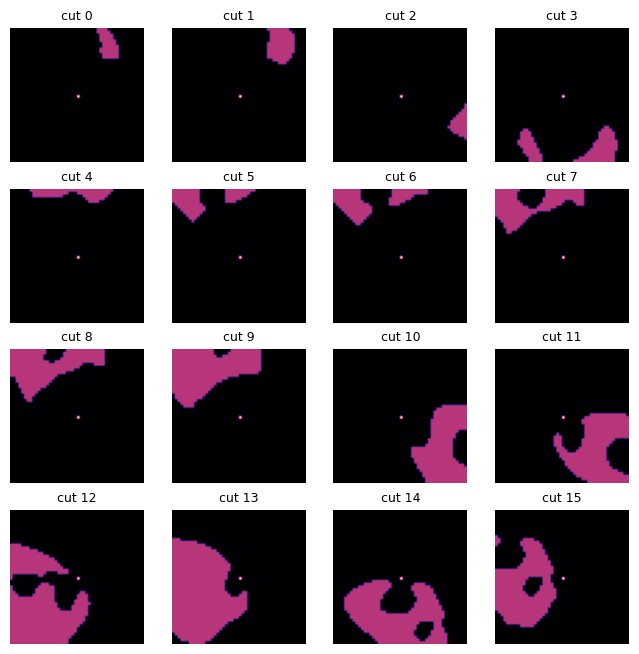

In [19]:
plot_cuts(seg_cuts)

comparison between cuts from the ground truth segmentation and cuts from the prediction
- red = ground truth
- purple = predicted segmentation
- orange = overlap

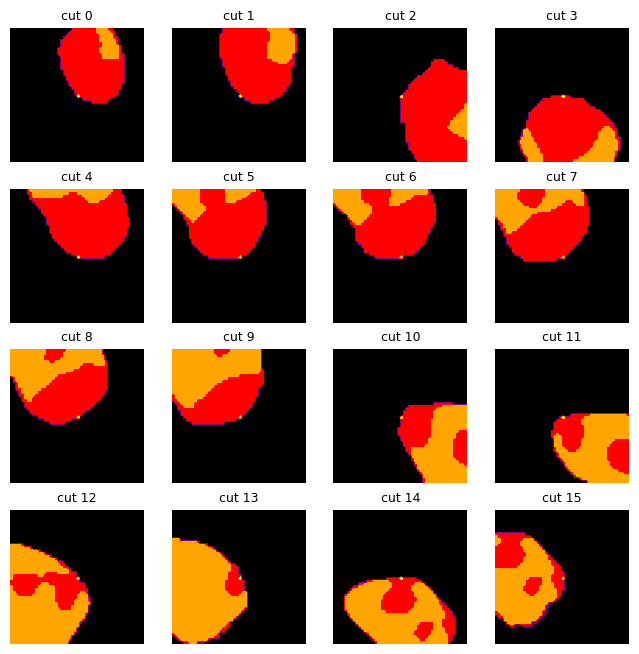

In [20]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)
plot_cuts_with_true(seg_cuts, true_cuts)

In [21]:
dsc = []
for x, y_true in zip(seg_cuts, true_cuts):
    dsc.append(dice_coefficient(x, y_true))
print(f'DSC for the generated cuts: {np.mean(dsc)}')

DSC for the generated cuts: 0.6928200125694275


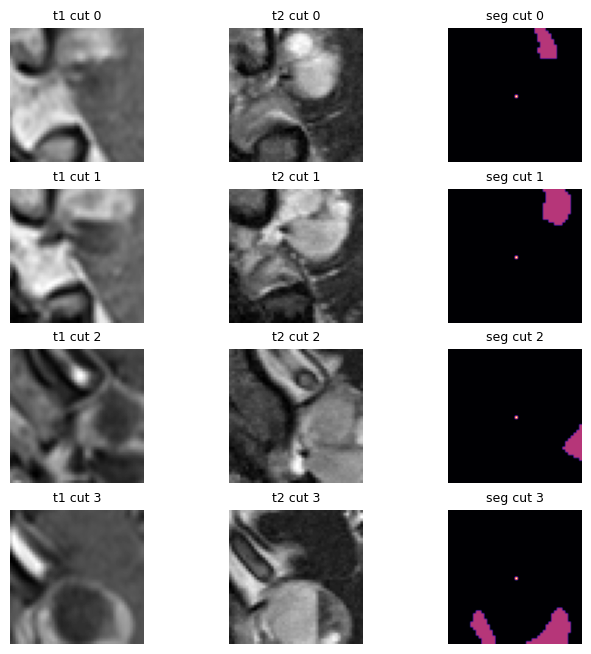

In [22]:
plot_cuts_with_seq(cuts)

#### Correction model

In [23]:
from src.model.correction import MultiModal3BlockCorrectionUnet

loading the correction model

In [24]:
checkpoint = torch.load(os.path.join("./models", "correction_model.pt"), map_location=device)
correction_model = MultiModal3BlockCorrectionUnet(in_channels=[1, 2], out_channels=1, blocks=3, encoders=2, block_channels=[32, 64, 128, 256], use_dropout=True, volumetric=False).to(device)
correction_model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [25]:
cutsize = 48

**Correcting cuts**

In [26]:
pred_cuts = []
with torch.no_grad():
    for cut in cuts:
        cut = cut.unsqueeze(0).to(device)
        y_pred = correction_model(cut)
        pred_cuts.append(y_pred.cpu())

In [27]:
for i, cut in enumerate(pred_cuts):
    pred_cuts[i] = cut.squeeze(0).cpu()

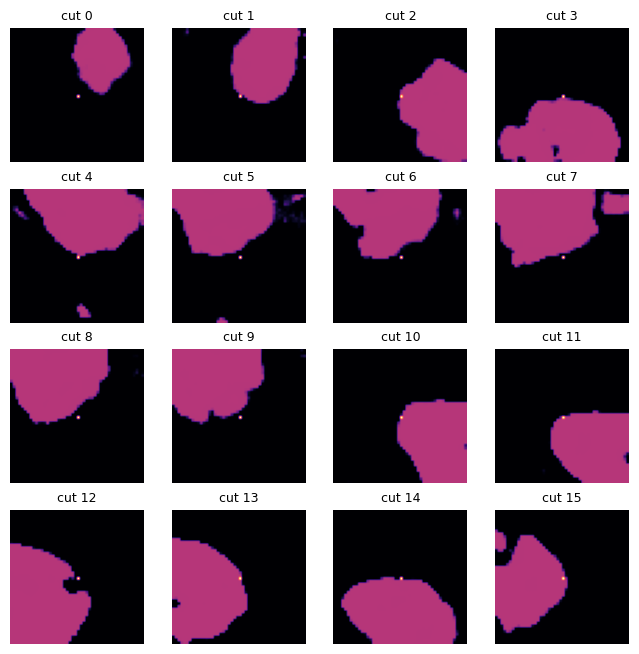

In [28]:
plot_cuts(pred_cuts)

comparison between the ground truth cuts and corrected cuts

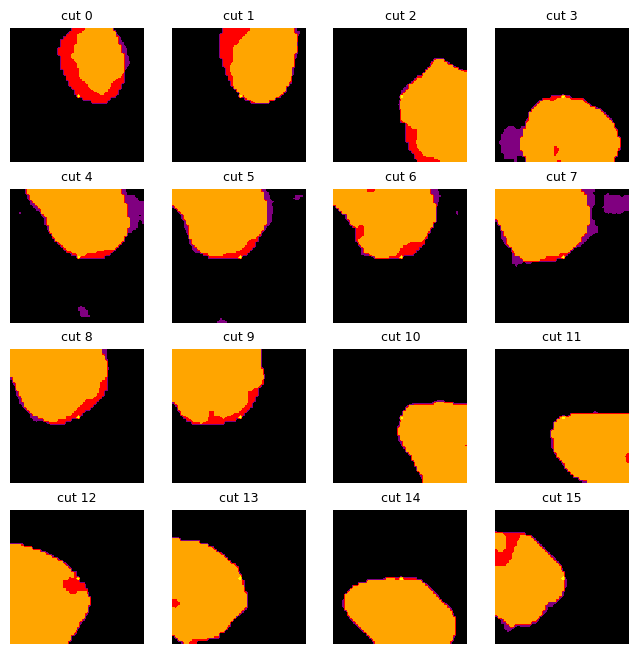

In [29]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)
plot_cuts_with_true(pred_cuts, true_cuts)

In [30]:
dsc = []
for x, y_true in zip(pred_cuts, true_cuts):
    dsc.append(dice_coefficient(x, y_true))
print(f'DSC for the corrected cuts: {np.mean(dsc)}')

DSC for the corrected cuts: 0.8593836426734924


#### Reconstruction of the volume

In [31]:
def reconstruct_volume(seg: torch.Tensor, clicks, cuts, cut_size=32, num: int = np.inf):
    cut_size = cut_size // 2  # needed only as a distance from the center

    # Get coordinates of the generated points
    click_coords = torch.nonzero(clicks[0])

    k = num if len(click_coords) > num else len(click_coords)
    for click_idx in range(0, k):
        coords = click_coords[click_idx]
        
        cut = cuts[click_idx]
        # print(cut.shape, coords)
        seg[0, coords[0], coords[1] - cut_size : coords[1] + cut_size, coords[2] - cut_size : coords[2] + cut_size] = cut 

    return seg

In [32]:
reconstructed_y = reconstruct_volume(y_threshed[0].clone(), new_clicks, pred_cuts, cut_size=cutsize)

In [33]:
print('DSC for the initial segmentation: ', dice_coefficient(y_threshed[0], y).item())

DSC for the initial segmentation:  0.7995458245277405


In [34]:
print('DSC for the reconstructed segmentation: ', dice_coefficient(reconstructed_y, y).item())

DSC for the reconstructed segmentation:  0.8945133090019226


Tumour indices:  25 41


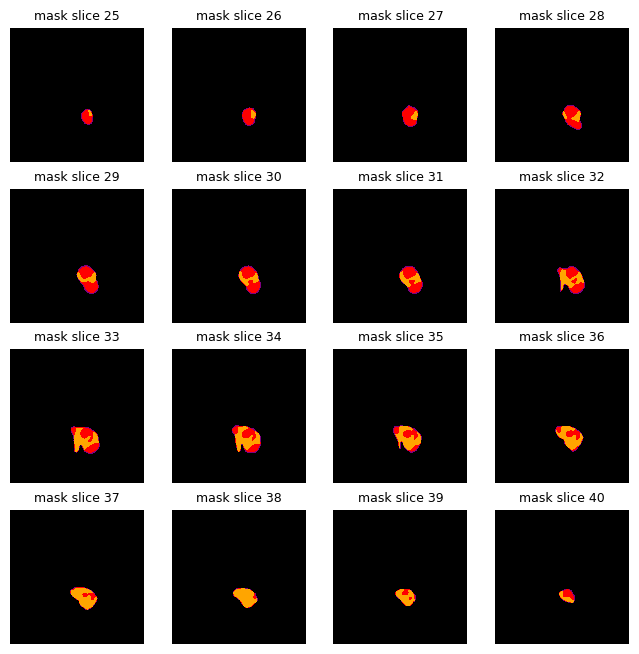

In [35]:
plot_tumour_with_true(y, y_threshed[0].detach())

Tumour indices:  25 41


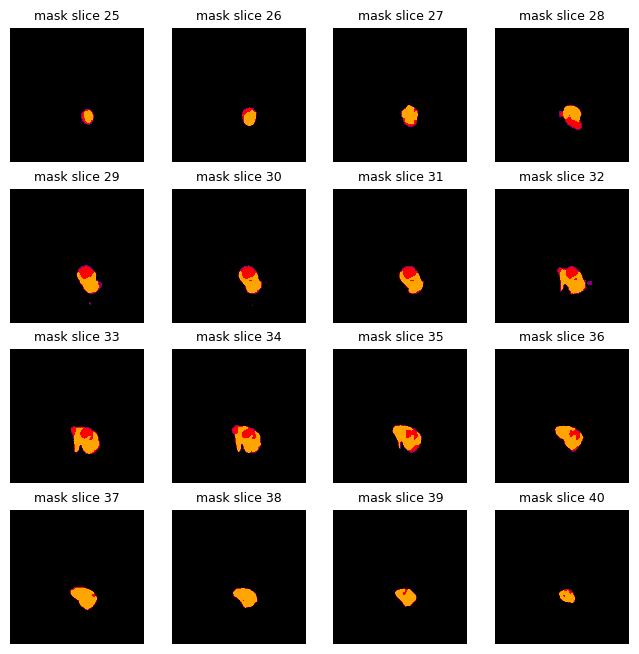

In [36]:
plot_tumour_with_true(y, reconstructed_y.detach())

#### Another iteration

In [37]:
x, y = new_data[0]

**generating new clicks and cuts**

In [38]:
new_clicks = simulate_clicks(y, reconstructed_y, clicks_num=5, clicks_dst=10)

In [40]:
seg_cuts, t1_cuts, t2_cuts = generate_cuts(reconstructed_y[0], x, new_clicks[0], cut_size=cutsize)

cuts = []
for seg_cut, t1_cut, t2_cut in zip(seg_cuts, t1_cuts, t2_cuts):
    cuts.append(torch.stack((seg_cut.squeeze(0), t1_cut.squeeze(0), t2_cut.squeeze(0))))

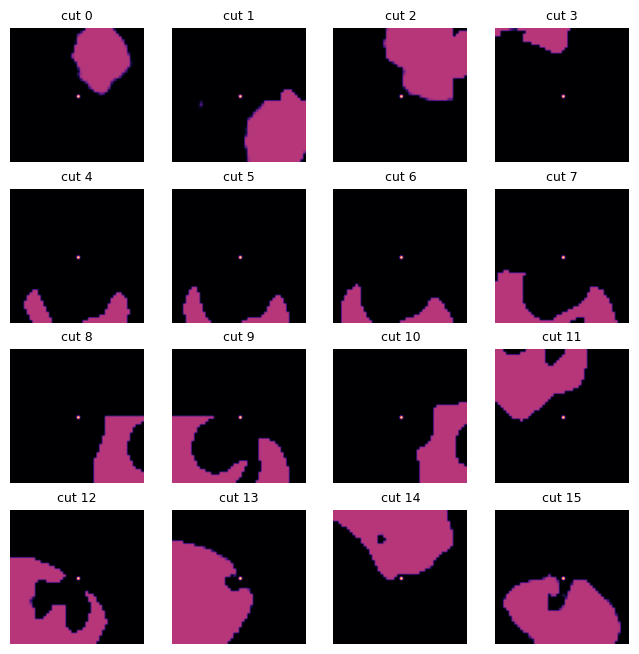

In [41]:
plot_cuts(seg_cuts)

**correcting cuts**

In [42]:
pred_cuts = []
with torch.no_grad():
    for cut in cuts:
        cut = cut.unsqueeze(0).to(device)
        y_pred = correction_model(cut)
        pred_cuts.append(y_pred)

In [43]:
for i, cut in enumerate(pred_cuts):
    pred_cuts[i] = cut.squeeze(0).cpu()

In [44]:
true_cuts = cut_volume(torch.stack((y[0], new_clicks[0])), cut_size=cutsize)

In [47]:
reconstructed_y = reconstruct_volume(reconstructed_y, new_clicks, pred_cuts, cut_size=cutsize)
print('DSC for the reconstructed segmentation: ', dice_coefficient(reconstructed_y, y).item())

DSC for the reconstructed segmentation:  0.9286720156669617


Tumour indices:  25 41


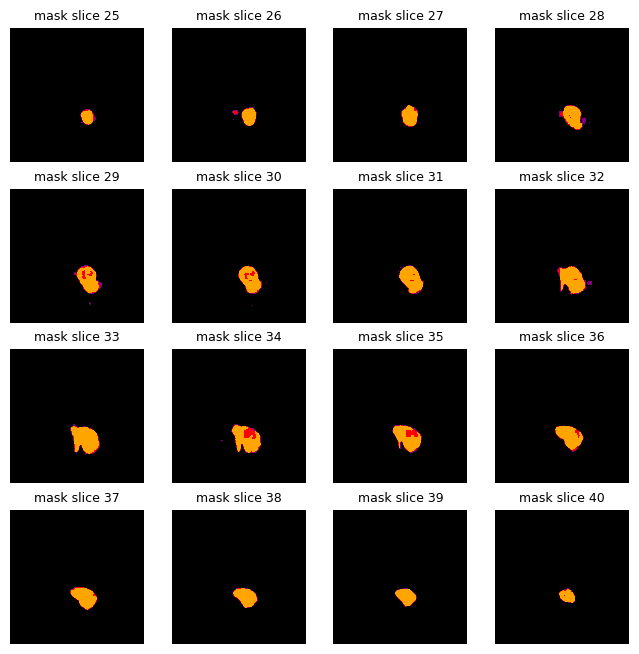

In [46]:
plot_tumour_with_true(y, reconstructed_y)